<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/GPR_yearlySeason.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
import matplotlib.pyplot as plt
import pandas as pd
import pylab as py
import seaborn as sns


,DOY,T,VPD,gamma,Delta,U,Rn,ET0,dET0,ET1,ET2,MA,ET3
TIMESTAMP,,,,,,,,,,,,,
1990-01-01,1,-26.7,0.008393,0.067381,4.799076,1.8,3.098325,1.236897,-2.047628,NaN,NaN,NaN,NaN
1990-01-02,2,-33.2,0.006802,0.067381,4.935265,0.0,3.149681,1.267761,-2.016763,0.030865,0.030865,1.236897,NaN
1990-01-03,3,-33.5,0.005730,0.067381,4.941713,0.0,3.172246,1.276866,-2.007658,0.024537,0.009105,1.252329,-0.021760
1990-01-04,4,-31.8,0.002196,0.067381,4.905367,0.0,1.194855,0.480895,-2.803629,-0.779613,-0.795971,1.260508,-0.805076
1990-01-05,5,-22.9,0.026560,0.067381,4.722477,1.8,3.223596,1.288056,-1.996468,0.222452,0.807161,1.065605,1.603132


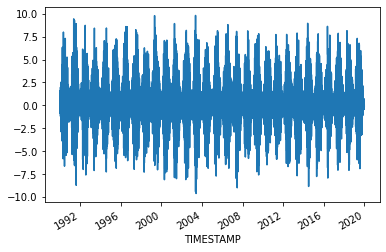

In [3]:
data = pd.read_excel('/content/drive/My Drive/50136-Mohe.xlsx')

for col in data.columns:
  newcol = col.split("(")[0]
  data.rename(columns={col:newcol}, inplace=True)

data.set_index("TIMESTAMP", inplace=True)

data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

data["dET0"] = data["ET0"]-np.median(data["ET0"])

data["ET1"] = data["ET0"] - data["ET0"].rolling('7d').apply(lambda x: x[:len(x)-1].mean())
data["ET2"] = data["ET0"] - data["ET0"].shift(1, freq='D')
data["MA"] = data["ET0"].rolling('7d').apply(lambda x: x[:len(x)-1].mean())
data["ET3"] = data["ET2"] - data["ET2"].shift(1, freq='D')

data["ET3"].plot()

data.head()

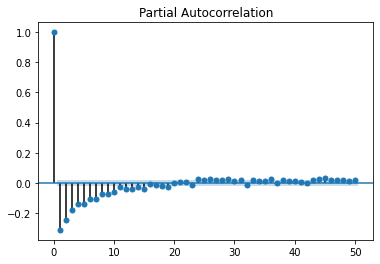

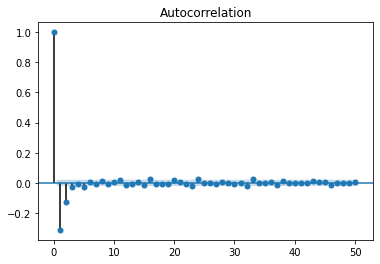

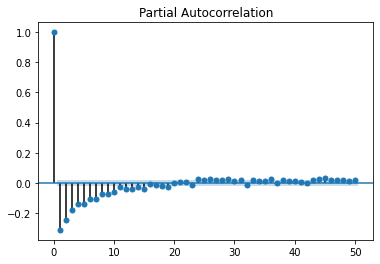

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = data["ET2"].ffill().bfill()#.fillna(1)

plot_acf(y, lags=50)
plot_pacf(y, lags=50)


Text(0, 0.5, 'ET0')

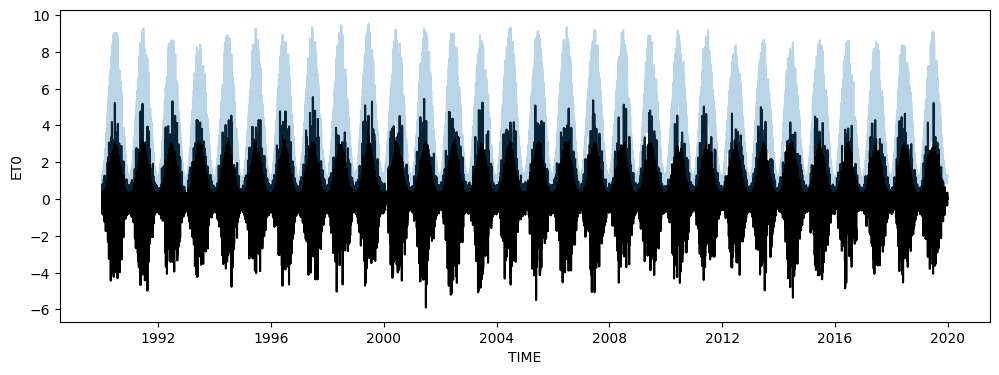

In [2113]:
fig = py.figure(figsize=(10, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

subData = data.loc["1990":]
N = len(subData)
x = subData.index



z = subData["ET2"].ffill()
y = subData["ET0"] 

ax.plot(x, z, 'k-')
ax.plot(x, y, alpha=0.3)
ax.set_xlabel("TIME")
ax.set_ylabel("ET0")

In [2114]:
subData.head(20)

,DOY,T,VPD,gamma,Delta,U,Rn,ET0,dET0,ET1,ET2,MA,ET3
TIMESTAMP,,,,,,,,,,,,,
1990-01-01,1,-26.7,0.008393,0.067381,4.799076,1.8,3.098325,1.236897,-2.047628,NaN,NaN,NaN,NaN
1990-01-02,2,-33.2,0.006802,0.067381,4.935265,0.0,3.149681,1.267761,-2.016763,0.030865,0.030865,1.236897,NaN
1990-01-03,3,-33.5,0.005730,0.067381,4.941713,0.0,3.172246,1.276866,-2.007658,0.024537,0.009105,1.252329,-0.021760
1990-01-04,4,-31.8,0.002196,0.067381,4.905367,0.0,1.194855,0.480895,-2.803629,-0.779613,-0.795971,1.260508,-0.805076
1990-01-05,5,-22.9,0.026560,0.067381,4.722477,1.8,3.223596,1.288056,-1.996468,0.222452,0.807161,1.065605,1.603132
1990-01-06,6,-27.9,0.011176,0.067381,4.823721,0.3,3.154401,1.267654,-2.016870,0.157559,-0.020402,1.110095,-0.827563
1990-01-07,7,-27.8,0.011750,0.067381,4.821659,0.0,1.299238,0.522783,-2.761741,-0.613571,-0.744871,1.136355,-0.724468
1990-01-08,8,-22.6,0.019174,0.067381,4.716522,0.0,3.049993,1.226870,-2.057655,0.209534,0.704086,1.017336,1.448957
1990-01-09,9,-34.0,0.004006,0.067381,4.952493,0.0,3.376555,1.359143,-1.925382,0.348622,0.132273,1.010521,-0.571813


In [2117]:
n = len(subData) # 1500
f = 0
prop_train = 0.8

y = subData["ET0"].ffill().values[f:f+n].reshape(n, 1)
z = subData["MA"].ffill().values[f:f+n].reshape(n, 1)

T = np.arange(n)

X = np.zeros((n,1))
X[:,0] = T 

n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [2118]:
X_train.shape

(8691, 1)

In [2119]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, ExpSineSquared, Matern, RationalQuadratic, ConstantKernel
from sklearn import linear_model

k0 = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(0.1**2, 0.8**2)) 
 
k1 = ConstantKernel(constant_value=50, constant_value_bounds=(1E-5, 100))

#  * \
#    ExpSineSquared(length_scale=0.03, periodicity=365, periodicity_bounds=(350, 380), length_scale_bounds=(0.01,0.06)) 
  
k2 = ConstantKernel(constant_value=1, constant_value_bounds=(10, 100)) * \
  RationalQuadratic(length_scale=1, length_scale_bounds=(1, 10), alpha= 1, alpha_bounds=(0.1, 2))

k3 = ConstantKernel(constant_value=1, constant_value_bounds=(1, 1000)) * \
  ExpSineSquared(length_scale=3,  periodicity=10, periodicity_bounds=(2, 10), length_scale_bounds=(1,5))

k4 = ConstantKernel(constant_value=10, constant_value_bounds=(1, 100)) * \
   ExpSineSquared(length_scale=5, periodicity=365, periodicity_bounds=(300, 400), length_scale_bounds=(1,10)) 

# k41 = ConstantKernel(constant_value=10, constant_value_bounds=(1E-5, 100)) * \
#    ExpSineSquared(length_scale=1, periodicity=350, periodicity_bounds=(1, 400), length_scale_bounds=(1,10)) 

  #  * \
  #  RBF(length_scale=10, length_scale_bounds=(1,20))

k5 = ConstantKernel(constant_value=1, constant_value_bounds=(1, 10)) * \
    RBF(length_scale=8, length_scale_bounds=(7,10))

k6 = ConstantKernel(constant_value=1, constant_value_bounds=(1, 10)) * \
    RBF(length_scale=4, length_scale_bounds=(3,7))    

k7 = ConstantKernel(constant_value=1, constant_value_bounds=(1, 10)) * \
    RBF(length_scale=2, length_scale_bounds=(1,3))    

k8 = ConstantKernel(constant_value=1, constant_value_bounds=(1, 10)) * \
    RBF(length_scale=13, length_scale_bounds=(10,15))    

kernel_4  =   k4 #+ k5# + k6 +k7 + k8 

In [2120]:
# Define GaussianProcessRegressor object. 
gp4 = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=20, 
    normalize_y=True,
    alpha=0.1
)

In [2121]:
gp4_prior_samples = gp4.sample_y(X=X, n_samples=2)


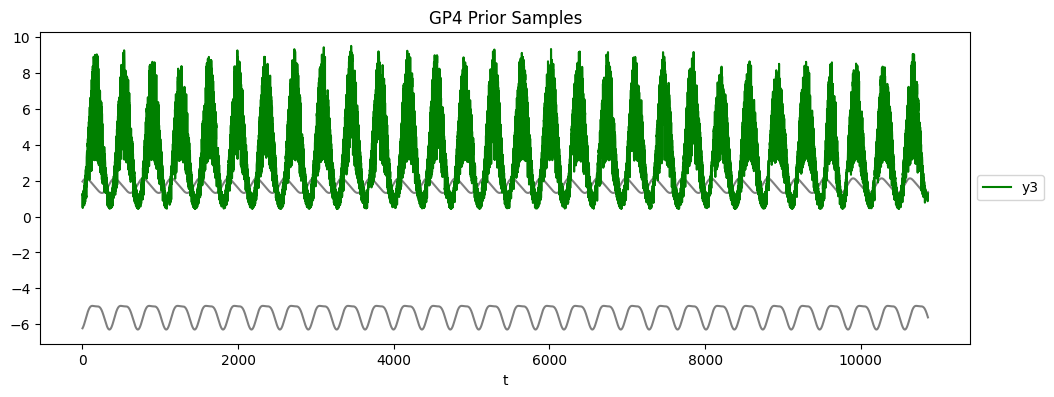

In [2122]:
fig = py.figure(figsize=(10, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

for i in range(2):
    sns.lineplot(x=T, y = gp4_prior_samples[:, i], color='k', alpha=0.5, ax=ax)
sns.lineplot(x=T, y=y[..., 0], color='g', label='y3', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP4 Prior Samples', xlabel='t');

# ax.set_xlim(0,800)

In [2123]:
t1 = datetime.now()
###########################################

gp4.fit(X_train, y_train)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

Execution time:
6:52:46.544259


In [2124]:
gp4.get_params()

{'alpha': 0.1,
 'copy_X_train': True,
 'kernel': 3.16**2 * ExpSineSquared(length_scale=5, periodicity=365),
 'kernel__k1': 3.16**2,
 'kernel__k1__constant_value': 10,
 'kernel__k1__constant_value_bounds': (1, 100),
 'kernel__k2': ExpSineSquared(length_scale=5, periodicity=365),
 'kernel__k2__length_scale': 5,
 'kernel__k2__length_scale_bounds': (1, 10),
 'kernel__k2__periodicity': 365,
 'kernel__k2__periodicity_bounds': (300, 400),
 'n_restarts_optimizer': 20,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [2125]:
y_pred, y_std = gp4.predict(X, return_std=True)


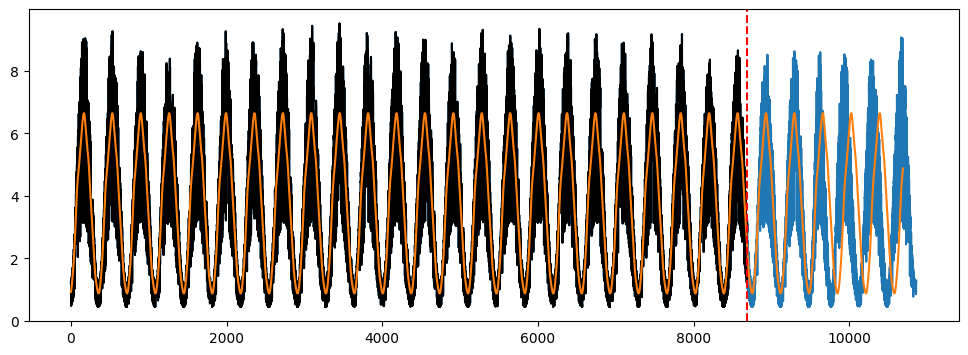

In [2129]:
fig = py.figure(figsize=(10, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(T, y)
# ax.plot(T, z, 'g.')
ax.plot(T[:n_train], y[:n_train], 'k-')


m = n_train+2000
xx = np.linspace(0,m,10000)
yy_pred, yy_std = gp4.predict(xx.reshape(10000,1), return_std=True)
ax.plot(xx, yy_pred)

ax.axvline(n_train, color='red', linestyle='--')

dd = 50
# ax.set_xlim(n_train-dd,n_train+dd)

In [2127]:
print(f'R2 Score Train = {gp4.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp4.score(X=X_test, y=y_test): 0.3f}')

R2 Score Train =  0.721
R2 Score Test = -0.137


In [1777]:
names = ["T"]
for i in range(10):
  names += ["y"+str(i)]
for i in range(10):
  names += ["yp"+str(i)]
for i in range(10):
  names += ["dyp"+str(i)]

dfOut = pd.read_csv("/content/drive/My Drive/outputGP.csv", names=names)

dfOut.head()

,T,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,yp0,yp1,yp2,yp3,yp4,yp5,yp6,yp7,yp8,yp9,dyp0,dyp1,dyp2,dyp3,dyp4,dyp5,dyp6,dyp7,dyp8,dyp9
0,450,1.747557,1.313527,1.923746,1.991679,1.858082,1.743005,2.139806,0.244126,-0.231102,1.409199,0.727785,0.797804,0.762554,0.734482,0.854026,1.185987,1.665012,2.121495,2.367549,2.292856,0.930125,0.941267,0.947548,0.949372,0.949469,0.949569,0.949797,0.949904,0.949911,0.949918
1,451,1.313527,1.923746,1.991679,1.858082,1.743005,2.139806,0.244126,-0.231102,1.409199,0.279571,0.484992,0.423229,0.531352,0.465338,0.547067,0.480891,0.275014,0.181103,0.327751,0.197493,0.871673,0.937623,0.979295,1.030822,1.084961,1.140187,1.194690,1.246804,1.295233,1.339041
2,452,1.923746,1.991679,1.858082,1.743005,2.139806,0.244126,-0.231102,1.409199,0.279571,-0.007267,0.930735,0.832760,0.883158,1.169988,1.635271,2.101836,2.365989,2.304721,1.936308,1.413866,0.924532,0.935692,0.941961,0.943764,0.943855,0.943960,0.944190,0.944296,0.944302,0.944310
3,453,1.991679,1.858082,1.743005,2.139806,0.244126,-0.231102,1.409199,0.279571,-0.007267,0.646387,2.376876,2.337331,1.803551,1.196374,0.473930,0.271413,0.705467,1.392716,1.863994,1.997833,1.002322,1.020118,0.944617,1.024076,1.021887,1.021179,1.023316,1.025398,1.025800,1.025758
4,454,1.858082,1.743005,2.139806,0.244126,-0.231102,1.409199,0.279571,-0.007267,0.646387,2.663244,1.539199,2.218725,1.863294,1.761023,2.333832,2.594925,2.816045,2.653007,2.611420,2.557751,0.595996,0.606578,0.686965,0.750365,0.827118,0.905829,0.985638,1.063374,1.136958,1.204672


1.2820881432086393 0.5978554623360026


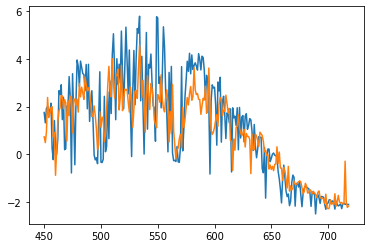

In [1153]:
plt.plot(dfOut["T"], dfOut["y0"])

plt.plot(dfOut["T"], dfOut["yp0"])



from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

RMSE = mean_squared_error(dfOut["y0"], dfOut["yp0"], squared=False)
R2 = r2_score(dfOut["y0"], dfOut["y1"])
print(RMSE, R2)

In [146]:


with open("/content/drive/My Drive/outputGP.csv", "w") as f:

  for n in range(450, len(y)-10):
    
      gp4.fit(X[:n], y[:n])
      y_pred, y_std = gp4.predict(X[n:n+10], return_std=True)

      # outList = [T[n]] + list(y[n:n+10].reshape(-1))
      outList = [T[n]] + list(y[n:n+10].reshape(-1))+ list(y_pred.reshape(-1)) + list(y_std.reshape(-1))

      st = ', '.join([str(x) for x in outList])
      f.write(st+'\n')
      # if n%50 == 0 :
      print(n, len(y)-10)



450 719
451 719
452 719
453 719
454 719
455 719
456 719
457 719
458 719
459 719
460 719
461 719
462 719
463 719
464 719
465 719
466 719
467 719
468 719
469 719
470 719
471 719
472 719
473 719
474 719
475 719
476 719
477 719
478 719
479 719
480 719
481 719
482 719
483 719
484 719
485 719
486 719
487 719
488 719
489 719
490 719
491 719
492 719
493 719
494 719
495 719
496 719
497 719
498 719
499 719
500 719
501 719
502 719
503 719
504 719
505 719
506 719
507 719
508 719
509 719
510 719
511 719
512 719
513 719
514 719
515 719
516 719
517 719
518 719
519 719
520 719
521 719
522 719
523 719
524 719
525 719
526 719
527 719
528 719
529 719
530 719
531 719
532 719
533 719
534 719
535 719
536 719
537 719
538 719
539 719
540 719
541 719
542 719
543 719
544 719
545 719
546 719
547 719
548 719
549 719
550 719
551 719
552 719
553 719
554 719
555 719
556 719
557 719
558 719
559 719
560 719
561 719
562 719
563 719
564 719
565 719
566 719
567 719
568 719
569 719
570 719
571 719
572 719
573 719
574 719


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


614 719
615 719
616 719
617 719
618 719
619 719
620 719
621 719
622 719
623 719
624 719
625 719
626 719
627 719
628 719
629 719
630 719
631 719
632 719
633 719
634 719
635 719
636 719
637 719
638 719
639 719
640 719
641 719
642 719
643 719
644 719
645 719
646 719
647 719
648 719
649 719
650 719
651 719
652 719
653 719
654 719
655 719
656 719
657 719
658 719
659 719
660 719
661 719
662 719
663 719
664 719
665 719
666 719
667 719
668 719
669 719
670 719
671 719
672 719
673 719
674 719
675 719
676 719
677 719
678 719
679 719
680 719
681 719
682 719
683 719
684 719
685 719
686 719
687 719
688 719
689 719
690 719
691 719
692 719
693 719
694 719
695 719
696 719
697 719
698 719
699 719
700 719
701 719
702 719
703 719
704 719
705 719
706 719
707 719
708 719
709 719
710 719
711 719
712 719
713 719
714 719
715 719
716 719
717 719
718 719
